# B-scan from a water pocket (2D)

INtro needed here

In [1]:
#import
from math import sqrt
import os

**Warning**: be careful with (hiden) open files. This may lead to error when running the code.

# Define (and plot) the builtin waveform

In the ``tools`` sub-package is a module called ``plot_source_wave`` which can be used to plot any of the builtin waveforms in time and frequency domains. The module takes the following arguments:

* ``type`` is the type of the waveform, e.g. ricker
* ``amp`` is the amplitude of the waveform
* ``freq`` is the centre frequency of the waveform
* ``timewindow`` is the time window used to view the waveform, i.e. the time window of the proposed simulation
* ``dt`` is the time step used to view the waveform, i.e. the time step of the proposed simulation

There is an optional argument:

* ``-fft`` a switch to turn on the FFT plotting for a single field component or current

For example (to use the module outside this notebook) to plot a Ricker waveform (and FFT) with an amplitude of 1, centre frequency of 25MHz and with a time window of 150ns and time step of 3.2ns:

    python -m tools.plot_source_wave ricker 1 25e6 3e-9 3.2e-9 -fft

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 0.980419
Centre frequency: 2.5e+07 Hz
Time to centre of pulse: 5.65685e-08 s
Time window: 1.5e-07 s (48 iterations)
Time step: 3.2e-09 s


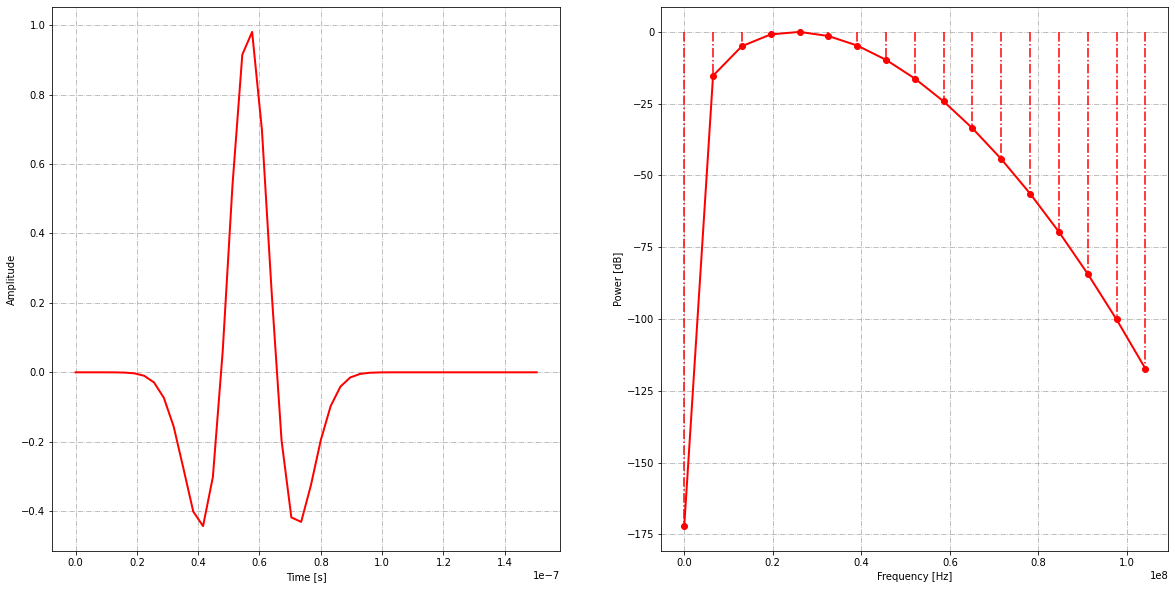

In [2]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 25e6
timewindow = 150e-9
dt = 3.2e-9

timewindow, iterations = check_timewindow(timewindow, dt)
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)

# Determining a suitable spatial model resolution

In [3]:
# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 80

# Maximum frequency present in model
fmax = 25e6 #3 times the central frequency

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution (allowing 10 cells per wavelength)
dmin = wmin / 10

# Time steps at CFL limits for cubic cells
dt3D = dmin / (sqrt(3) * c)
dt2D = dmin / (sqrt(2) * c)

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))
print('Time step for 3D cubic cell: {:g} s'.format(dt3D))
print('Time step for 2D square cell: {:g} s'.format(dt2D))

Minimum wavelength: 1.34071 m
Maximum spatial resolution: 0.134071 m
Time step for 3D cubic cell: 2.58199e-10 s
Time step for 2D square cell: 3.16228e-10 s


The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).

# Define time windows

In [4]:
d = 30 #depth of the studied object
er=3.2 #relative permittivity of the medium=ice
t = (2 * d) / (c / sqrt(er))
print('Minimum time window: {:g} s'.format(t))

Minimum time window: 3.58019e-07 s


# Build the model space

See [gprMax doc about building environment](http://docs.gprmax.com/en/latest/examples_simple_2D.html)

In [5]:
#HERE: build a if condition (e.g. if snow or snow free) to build space domain and filename accordingly

In [6]:
#paths and filenames
file="waterpocket_snowfree_2D" #file name
direname="../../user_models/"+file #folder path
basename=os.path.join(direname,file) #filename path (=name of the model)
fname=basename+".in" #filename path input defined bellow

#cretation of the sub folder un gprMax/user_model/.. if not existing already
if not os.path.isdir(direname): 
    os.makedirs(direname)

In [7]:
#note: there is a better and more robust way to define an input file: see gprMax/gprMax/input_cmd_funcs.py

In [8]:
%%writefile {fname}
#title: B-scan from a water pocket buried in a snowfree ice 2D-space
#domain: 50 40 0.1
#dx_dy_dz: 0.1 0.1 0.1
#time_window: 400e-9

#material: 3.2 5e-8 1 0 ice
#material: 6 0.001 1 0 granite
#material: 80 0.0005 1 0 fresh_water


#waveform: ricker 1 25e6 my_ricker
#hertzian_dipole: z 1 30.5 0 my_ricker
#rx: 5 30.5 0
#src_steps: 1 0 0
#rx_steps: 1 0 0

#box: 0 0 0 50 30 0.1 ice
#box: 0 0 0 50 5 0.1 granite
#sphere: 25 15 0 3 fresh_water

#python:
from gprMax.input_cmd_funcs import *
for i in range(1, 40):
    snapshot(0, 0, 0, 50, 40, 0.1, 0.1, 0.1, 0.1, i*10e-9, 'snapshot' + str(i))
#end_python:

#geometry_view: 0 0 0 50 40 0.1 0.1 0.1 0.1 waterpocket_snowfree n

Writing ../../user_models/waterpocket_snowfree_2D\waterpocket_snowfree_2D.in


In [9]:
#To change if snowcovered:
#title
#geometry title
#material: 50 1e-6 1 0 wet_snow
#box: 0 30 0 50 32.5 0.1 wet_snow
#hertzian_dipole: z 1 32.5 0 my_ricker
#rx: 5 32 0

In [10]:
##python:
#from gprMax.input_cmd_funcs import *
#for i in range(1, 100):
    #snapshot(0, 0, 0, 50, 50, 0.1, 0.1, 0.1, 0.1, i*10e-9, 'snapshot' + str(i))
##end_python:

In [11]:
#or: #snapshot: 0 0 0 50 50 0.1 0.1 0.1 0.1 {} snapshot{}'.format(i*10e-9, i)

Note: '{}' allow fname to be taken as a path (=string), and not as a name.

For geometry view while running the code: `#geometry_view: 0 0 0 50 50 0.15 0.15 0.15 0.15 fname n`

The differences between this input file and the one from the A-scan are the x coordinates of the source and receiver, and the commands needed to move the source and receiver. As before, the source and receiver are offset by 40mm from each other as before but they are now shifted to a starting position for the scan. The ``#src_steps`` command is used to move every source in the model by specified steps each time the model is run. Similarly, the ``#rx_steps`` command is used to move every receiver in the model by specified steps each time the model is run. Note, the same functionality can be achieved by using a block of Python code in the input file to move the source and receiver individually (for further details see the Python section of the User Guide).

# Run the model

To run the model to create a B-scan you must pass an optional argument to specify the number of times the model should be run. In this case this is the number of A-scans (traces) that will comprise the B-scan. For a B-scan over a distance of 120mm with a step of 2mm that is 60 A-scans. You can now run the model using:
    
    python -m gprMax user_models/cylinder_Bscan_2D.in -n 60

### Check Geometry (without running simulation)

In [12]:
#from gprMax.gprMax import api
#check geometry and modelling constrain first
#api(fname, n=5, geometry_only=True)

### Run simulations

In [13]:
#run the model
from gprMax.gprMax import api
api(fname, n=40, geometry_only=False)


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method =======================

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.5 (Big Smoke)

 Copyright (C) 2015-2020: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as
  published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty
  of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License

## View the results

### Merge A-scans into B-scan

You should have produced 60 output files, one for each A-scan, with names ``my_cylinder_Bscan_2D1.out``, ``my_cylinder_Bscan_2D2.out`` etc... These can be combined into a single file using the command:

    python -m tools.outputfiles_merge user_models/cylinder_Bscan_2D

In [14]:
from tools.outputfiles_merge import merge_files
merge_files(basename, removefiles=False)

You should see a combined output file ``basename_merged.out``. Delete the original single A-scan output files or keep them with the argument.

### Plot the B-scan

You can plot the B-scan using:

    python -m tools.plot_Bscan user_models/cylinder_Bscan_2D_merged.out Ez

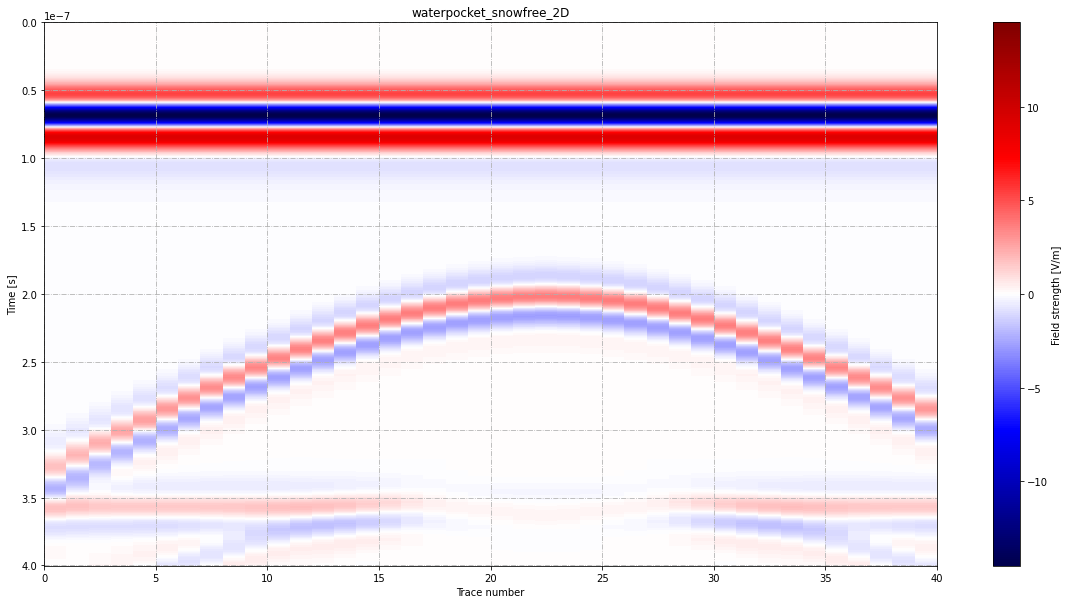

In [15]:
%matplotlib inline
import os
from tools.plot_Bscan import get_output_data, mpl_plot

outputname = basename+'_merged.out' #output file path
rxnumber = 1
rxcomponent = 'Ez'
outputdata, dt = get_output_data(outputname, rxnumber, rxcomponent)
plt = mpl_plot(outputname,outputdata, dt, rxnumber, rxcomponent)
plt.title(file)
plt.savefig(basename+'_plot.png')
# Change from the default 'seismic' colormap
#plt.set_cmap('gray')

The B-scan (of the $E_z$ field component) shows the initial part of the signal (~0.5-1.5 ns) which represents the direct wave from transmitter to receiver. Then comes the refelected wave (~2-3 ns) from the metal cylinder which creates the hyperbolic shape.